## Fluid diffusion in a poroelastic medium

- Implicit 2D finite-difference scheme for diffusion equation following Beck and Kaus (2020): https://www-udc.ig.utexas.edu/external/becker/Geodynamics557.pdf

- Current set up is for a (firn) aquifer with zero flux at the top and bottom boundaries, except for a region of radius r at the top of the aquifer where a constant flux is prescribed for 30 days and then set to 0. The edge boundary conditions are set to zero increase in fluid mass. 

In [1]:
from matplotlib import rcParams
rcParams['font.family'] = 'Avenir'
rcParams['font.size'] = 16
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
import time

In [2]:
# Physical parameters
L = 50e3 # Width of domain [m]
H = 30 # Height of domain [m]
r = 500 # radius over which flux is applied [m]

K = 1.5e-4 # Hydraulic conductivity of firn [m/s]
S = 1e-4  # Storage coefficient (a function of elastic and poroelastic parameters) [1/m]

c = K/S # Hydraulic diffusivity [m^2/s]

q = 0.001 #input flux over radius r [kg/m^4]

# Numerical parameters
dt = 1e5 # timestep [s]
nx = 200 # gridpoints in x-direction
nz = 30 # gridpoints in z-direction
nt = 200 # Number of timesteps to compute
dx = L/(nx-1) # Spacing of grid in x-direction
dz = H/(nz-1) # Spacing of grid in z-direction
[x2d,z2d]= np.meshgrid(np.arange(-L/2,L/2+dx,dx),np.arange(-H,0+dz,dz))
x = x2d[1,:]
z = z2d[:,1]
Number = np.arange(0,nx*nz) 
Number = Number.reshape(x2d.shape) # Array of indices

# Setup array for change in fluid mass \delta_m [kg/m^3 of aquifer]
delta_m = np.zeros(z2d.shape)

In [3]:
# Construct the A matrix:
A = np.eye(nx*nz)
sx = c*dt/dx**2
sz = c*dt/dz**2

for i in np.arange(0,nz):
    for j in np.arange(1,nx-1):
        if i == 0:                                     #Set up A for bottom flux boundary
            A[Number[i,j],Number[i+1,j]] = -2*sz
            A[Number[i,j],Number[i,j+1]] = -sx
            A[Number[i,j],Number[i,j]] = 1+2*sz+2*sx
            A[Number[i,j],Number[i,j-1]] = -sx
        elif i == nz-1:                                #Set up A for top flux boundary
            A[Number[i,j],Number[i,j+1]] = -sx
            A[Number[i,j],Number[i,j]] = 1+2*sz+2*sx
            A[Number[i,j],Number[i-1,j]] = -2*sz
            A[Number[i,j],Number[i,j-1]] = -sx
        else:                                          #Set up the main A matrix
            A[Number[i,j],Number[i+1,j]] = -sz
            A[Number[i,j],Number[i,j+1]] = -sx
            A[Number[i,j],Number[i,j]] = 1+2*sz+2*sx
            A[Number[i,j],Number[i-1,j]] = -sz
            A[Number[i,j],Number[i,j-1]] = -sx

A_sparse = csr_matrix(A)
A_inv = inv(A_sparse) # Take the inverse of the constant A matrix

/usr/local/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


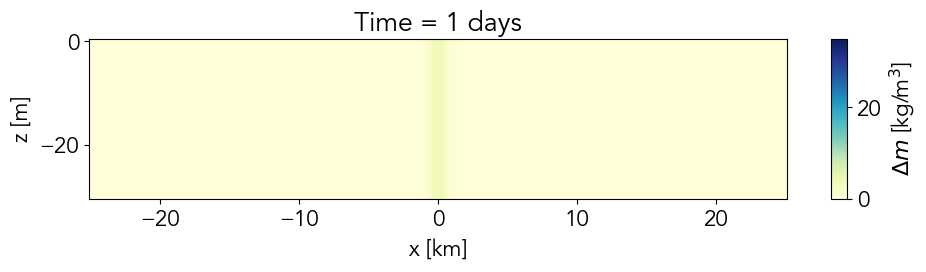

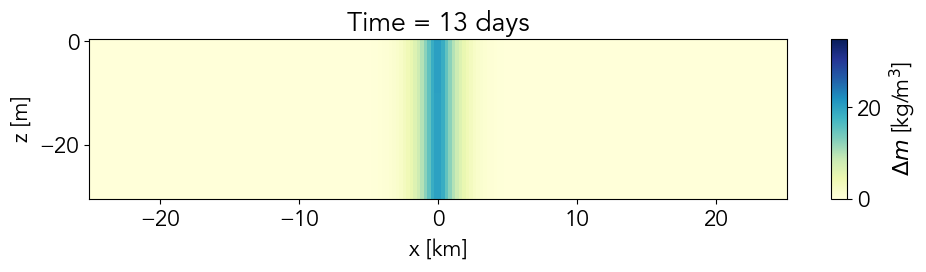

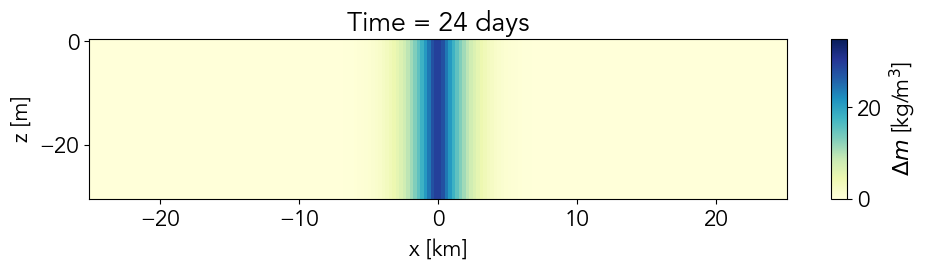

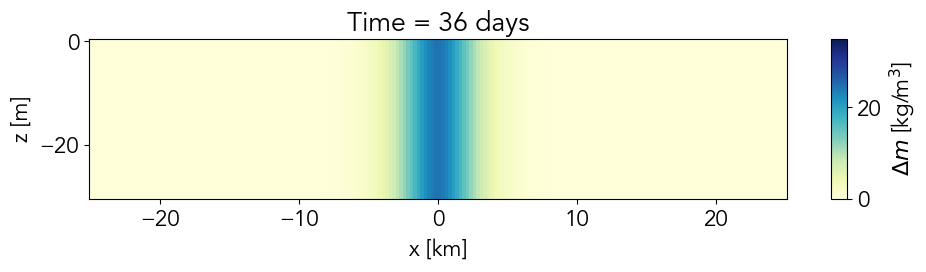

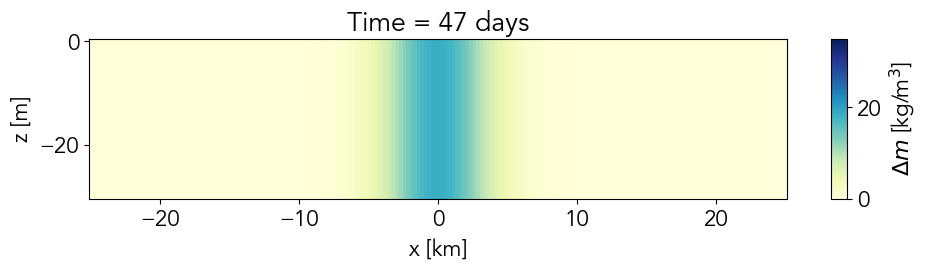

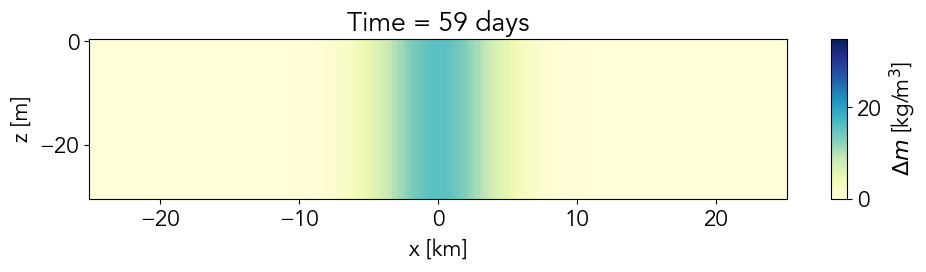

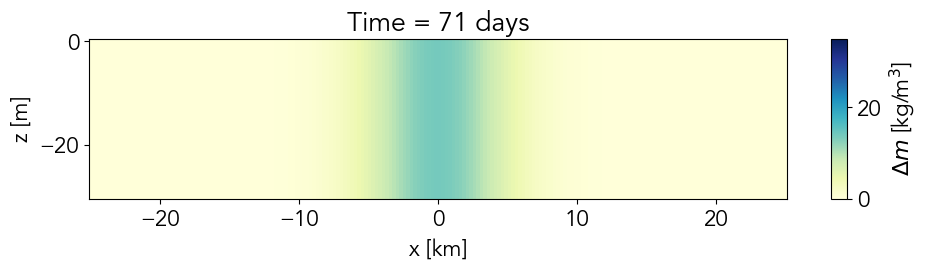

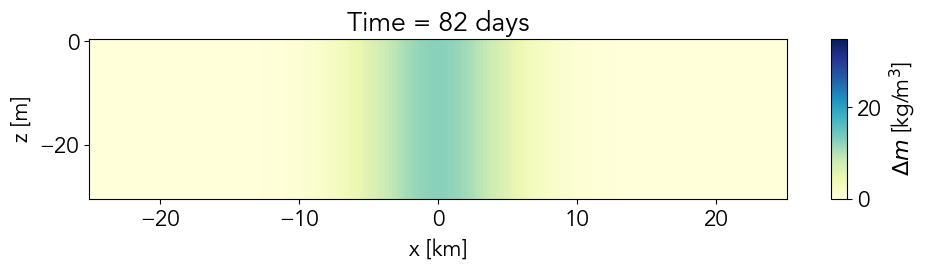

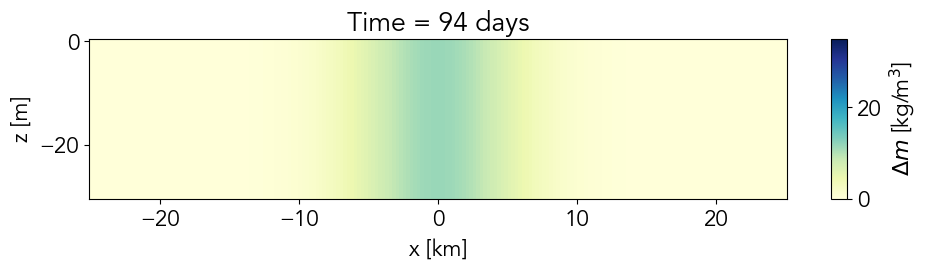

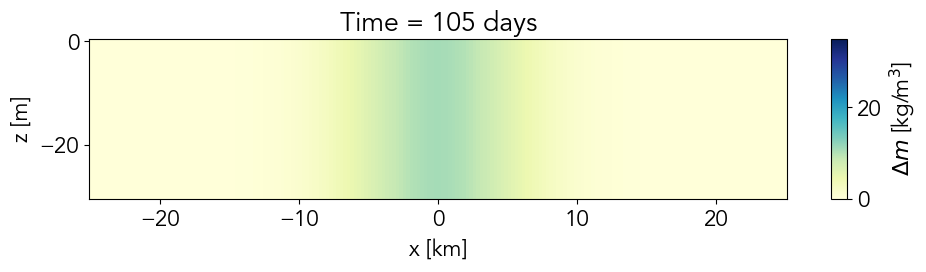

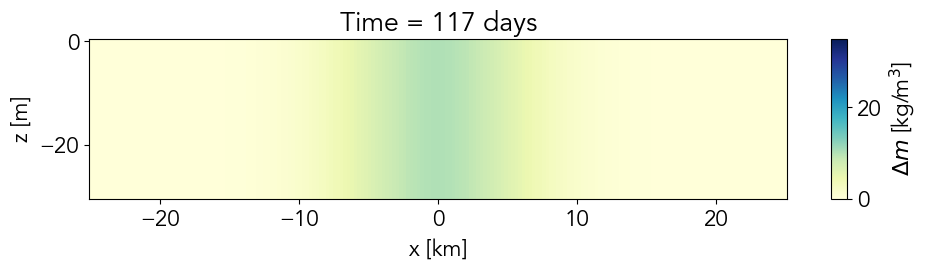

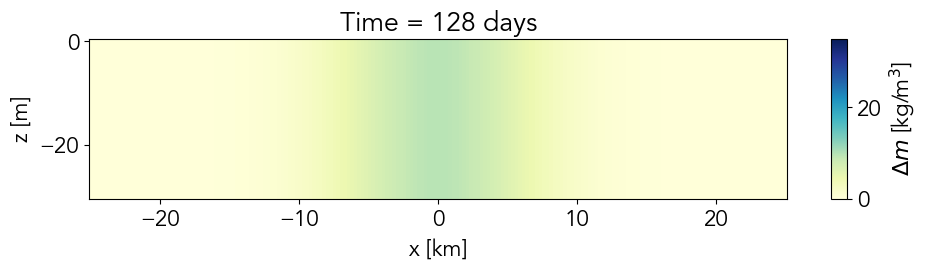

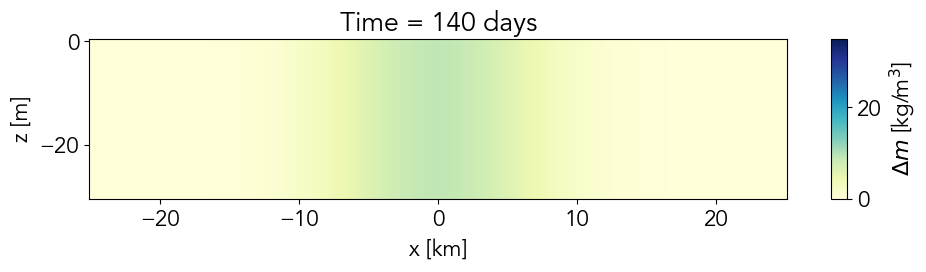

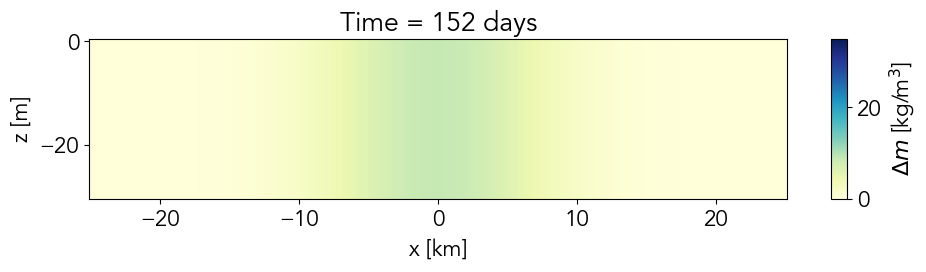

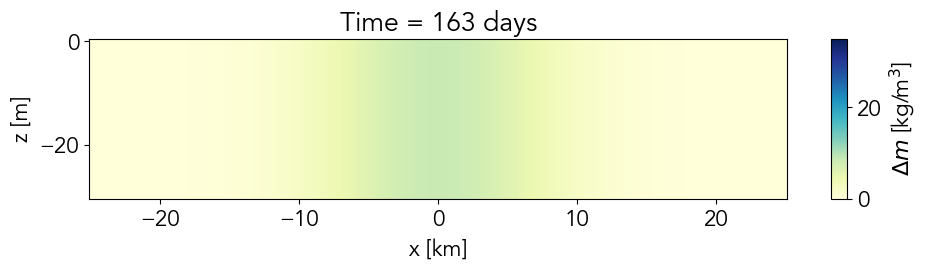

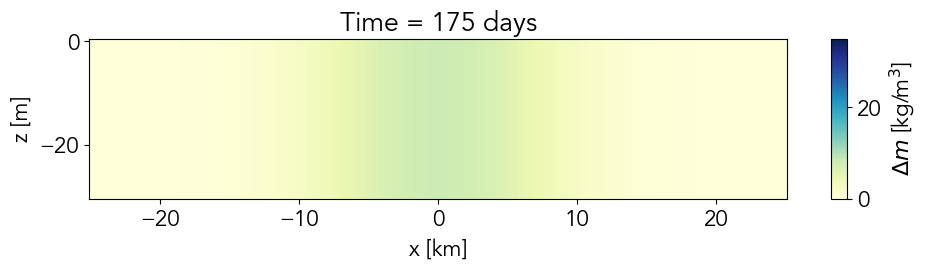

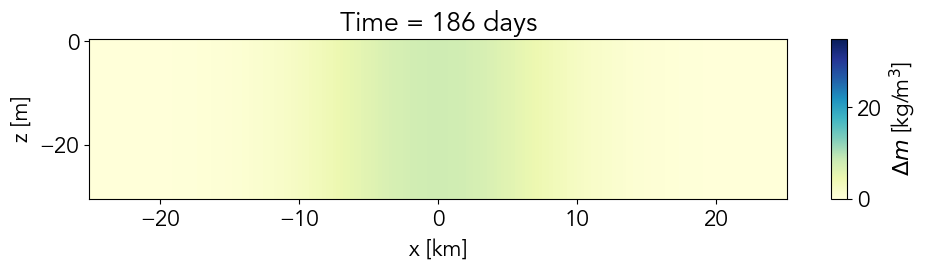

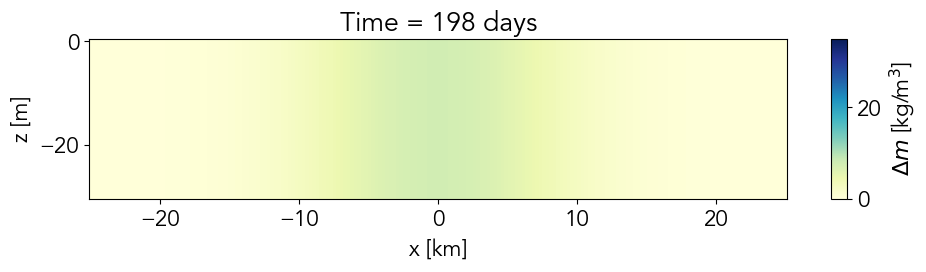

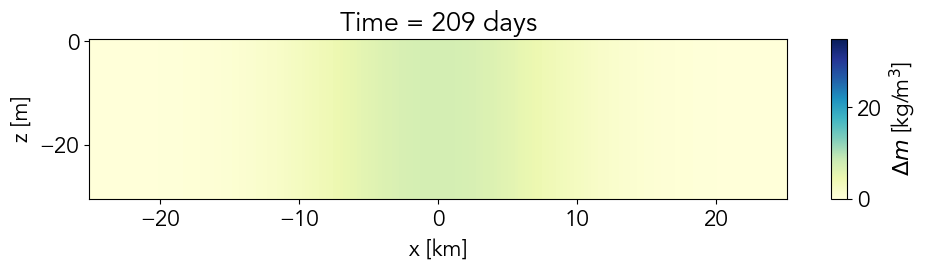

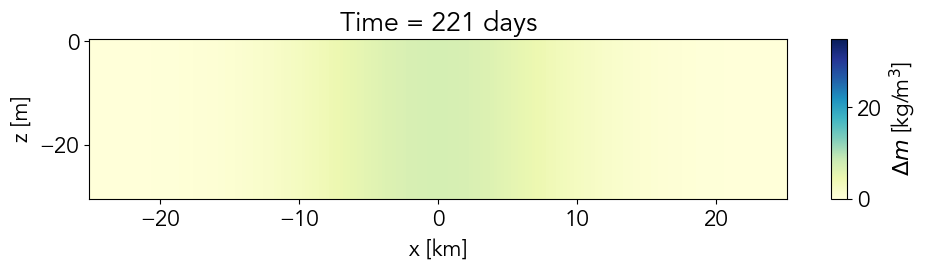

In [4]:
# Main loop over time:

delta_m_stored = np.zeros([nt,nx]) # Array to store a profile at each time step
time = 0

for n in np.arange(0,nt):
    rhs = delta_m.flatten()        # Set right-hand side of the equation to delta_m at time = n-1
    if time > 30*24*3600:          # Set flux to 0 after 30 days
        q = 0
    for j in np.arange(1,nx):
        if np.abs(x[j])<=r:       # Prescribe flux over radius r 
            rhs[-j-1] = rhs[-j-1]+2*sz*dz*q
    
    delta_m_vector = A_inv*rhs     # compute solution vector
    delta_m = delta_m_vector.reshape(x2d.shape)
    delta_m_stored[n,:]=delta_m[int(nz/2),:]   #Store profile
    time = time + dt
    
    #Plots
    
    if np.mod(n,10)==0: 

        fig, ax = plt.subplots(figsize = (10,3))

        plt.pcolor(x2d/1e3,z2d,delta_m,cmap='YlGnBu',shading = 'auto',vmin=0, vmax=35)
        cb = plt.colorbar(ax=ax,aspect=10)
        cb.set_label(label='$\Delta m$ [kg/m$^3$]')
        cb.ax.tick_params(labelsize=16)

        ax.set_xlabel("x [km]")
        ax.set_ylabel("z [m]")
        ax.set_title('Time = '+str(round(time/3600/24))+' days')
        plt.tight_layout()

        plt.show()


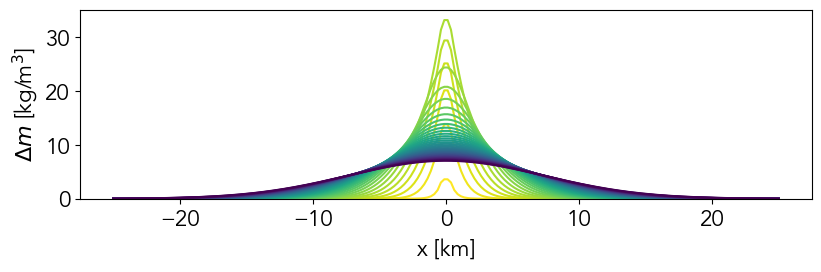

In [5]:
#Plot evolution of profiles over time

dt_plot = 5

fig, ax = plt.subplots(figsize = (8.5,3))

color = iter(cm.viridis_r(np.linspace(0, 1, int(nt/dt_plot))))

for i in range(0,nt,dt_plot):
    c = next(color)
    ax.plot(x/1e3,delta_m_stored[i,:], c=c)
    
ax.set_xlabel("x [km]")
ax.set_ylabel("$\Delta m$ [kg/m$^3$]")
ax.set_ylim([0, 35])
plt.tight_layout()

plt.show()  